In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import norm
from scipy.interpolate import griddata
import math
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [2]:
def calulate_greeks(S, K, T, r, sigma, option_type='call'):
    """Calculate the Greeks for European options using Black-Scholes formula.
    option_type: 'call' or 'put'
    Returns a dictionary with Delta, Gamma, Theta, Vega, Rho.
    """
    if T <= 0:
        if option_type == 'call':
            intrinsic_value = max(0, S - K)
            delta = 1.0 if S > K else 0.0
        else:  # put
            intrinsic_value = max(0, K - S)
            delta = -1.0 if S < K else 0.0
        return {
            'price': intrinsic_value,
            'delta': delta,
            'gamma': 0.0,
            'theta': 0.0,
            'vega': 0.0,
            'rho': 0.0
        }
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    n_d1 = norm.pdf(d1)  # for gamma and vega
    # option price
    if option_type == 'call':
        price = S * N_d1 - K * math.exp(-r * T) * N_d2
        delta = N_d1
        rho = K * T * math.exp(-r * T) * N_d2 / 100  # per 1% change in r
    else:
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = N_d1 - 1
        rho = -K * T * math.exp(-r * T) * norm.cdf(-d2) / 100
    # common greeks
    gamma = n_d1 / (S * sigma * math.sqrt(T))
    theta = (- (S * n_d1 * sigma) / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * N_d2) / 365 if option_type == 'call' else \
            (- (S * n_d1 * sigma) / (2 * math.sqrt(T)) + r * K * math.exp(-r * T) * norm.cdf(-d2)) / 365
    vega = S * n_d1 * math.sqrt(T) / 100  # per 1% change in volatility
    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega,
        'rho': rho
    }

Delta hedge simulation:
Position: Short 100 BTC strike 120000 Call Options
Initial BTC Price: 115000, Time to Maturity: 30 days, Volatility: 80.00%, Risk-free rate: 5.00%
, Initial Delta: 0.4789, Initial Hedge Position: 47.89 BTC


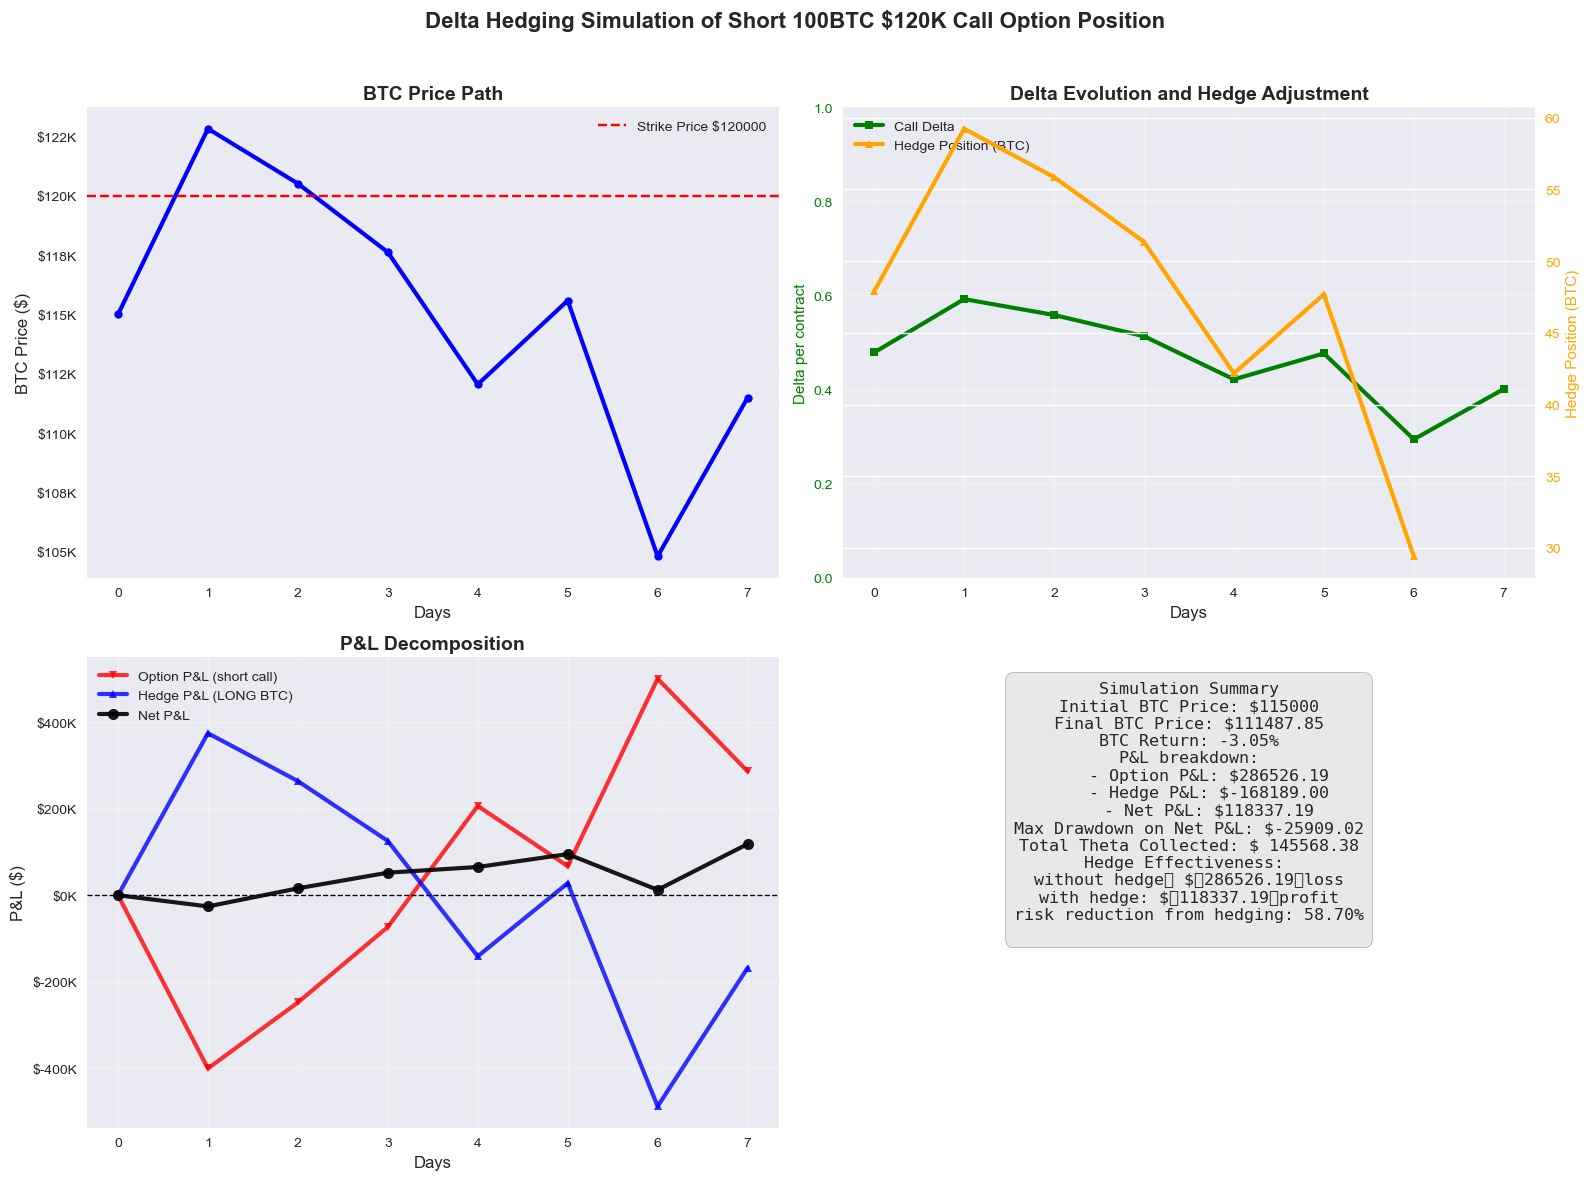

Detailed Daily Analysis:
Day  BTC Price      Option Price   Delta     Hedge Pos (BTC)Option P&L ($) Hedge P&L ($)  Net P&L ($)    
----------------------------------------------------------------------------------------------------
0    115000.00      8600.57        0.4789    47.89          0.00           0.00           0.00           
1    122822.04      12605.46       0.5923    59.23          -400489.23     374580.21      -25909.02      
2    120511.16      11080.44       0.5585    55.85          -247986.98     263917.20      15930.23       
3    117619.12      9333.46        0.5134    51.34          -73289.03      125423.74      52134.72       
4    112052.30      6536.12        0.4217    42.17          206445.27      -141159.10     65286.17       
5    115582.51      7929.14        0.4768    47.68          67143.12       27895.30       95038.42       
6    104807.46      3594.72        0.2942    29.42          500584.73      -488098.61     12486.11       
7    111487.85      5735.3

In [3]:
#Delta Hedge Simulation
print("Delta hedge simulation:" )
print("=="*30)
initial_btc_price = 115000
strike = 120000
T_initial = 30 / 365
r = 0.05
sigma  = 0.8
contracts = -100

print(f"Position: Short {abs(contracts)} BTC strike {strike} Call Options")
print(f"Initial BTC Price: {initial_btc_price}, Time to Maturity: {T_initial*365:.0f} days, Volatility: {sigma*100:.2f}%, Risk-free rate: {r*100:.2f}%")
np.random.seed(1)
#generafe realistic price path
days = 8
dt = 1/365
price_path = [initial_btc_price]
daily_returns = []
for i in range(days-1):
    #generate daily return with some autocorreation
    daily_vol = sigma / math.sqrt(365)
    if i == 0:
        daily_return = np.random.normal(0, daily_vol)
    else:
        daily_return = 0.1 * daily_returns[-1] + np.random.normal(0, daily_vol)

    daily_returns.append(daily_return)
    new_price = price_path[-1] * (1+daily_return)
    price_path.append(new_price)

#Calculate option value and greeks throught the path
option_values = []
deltas = []
hedge_poitions = []
option_pnl = []
hedge_pnl = []
net_pnl = []
times_to_expiry = []

#Initial option greeks
initial_greeks = calulate_greeks(initial_btc_price, strike, T_initial, r, sigma, option_type='call')
initial_option_price = initial_greeks['price']
hedge_poition = -contracts * initial_greeks['delta'] #delta hedge
hedge_poitions.append(hedge_poition)

print(f", Initial Delta: {initial_greeks['delta']:.4f}, Initial Hedge Position: {hedge_poition:.2f} BTC")
#track value over time
for day, btc_price in enumerate(price_path):
    T_current = max(T_initial - day * dt, 0.001)
    times_to_expiry.append(T_current)
    current_greeks = calulate_greeks(btc_price, strike, T_current, r, sigma, option_type='call')
    option_values.append(current_greeks['price'] )
    deltas.append(current_greeks['delta'])
    times_to_expiry.append(T_current)
    if day ==0:
        option_pnl.append(0)
        hedge_pnl.append(0)
        net_pnl.append(0)
    else:
        option_change = (current_greeks ['price'] - initial_option_price)* contracts
        option_pnl.append(option_change)
        #hedge pnl
        btc_change = btc_price - initial_btc_price
        hedge_change = hedge_poition * btc_change
        hedge_pnl.append(hedge_change)
        net_pnl.append(option_change + hedge_change)
        #rehedge for next day
        if day < len(price_path) -1:
            new_hedge = -contracts * current_greeks['delta']
            hedge_poitions.append(new_hedge)

#create comprehensive visualizstion
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,12))
fig.suptitle("Delta Hedging Simulation of Short 100BTC $120K Call Option Position", fontsize=16, fontweight='bold')
days_axis = list(range(days))
#Panel 1: BTC Price Path
ax1.plot(days_axis, price_path,"b-",linewidth=3,marker='o',markersize=6)
ax1.axhline(strike, color='r', linestyle='--', label=f'Strike Price ${strike}')
ax1.set_title("BTC Price Path", fontsize=14, fontweight='bold')
ax1.set_xlabel("Days", fontsize=12)
ax1.set_ylabel("BTC Price ($)", fontsize=12)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p:f"${x/1000:.0f}K"))
ax1.grid()
ax1.legend()

#Panel 2 Delta aand Hedge Position
ax2_twin = ax2.twinx()

#PLot delta
line1 = ax2.plot(days_axis, deltas,"g-",linewidth=3,marker='s',markersize=6, label='Call Delta')
ax2.set_ylabel("Delta per contract", color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(0,1)

#plot hedge position on secondary axis
line2 = ax2_twin.plot(days_axis[:-1], hedge_poitions,"orange",linewidth=3,marker='^',markersize=6, label='Hedge Position (BTC)')
ax2_twin.set_ylabel("Hedge Position (BTC)", color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

ax2.set_title("Delta Evolution and Hedge Adjustment", fontsize=14, fontweight='bold')
ax2.set_xlabel("Days", fontsize=12)
ax2.grid(True,alpha=0.3)
#combined legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

#Panel 3 P&L components
ax3.plot(days_axis, option_pnl,"r-",linewidth=3,marker='v', markersize=6, label='Option P&L (short call)',alpha=0.8)
ax3.plot(days_axis, hedge_pnl,"b-",linewidth=3,marker='^', markersize=6, label='Hedge P&L (LONG BTC)',alpha=0.8)
ax3.plot(days_axis, net_pnl,"k-",linewidth=3,marker='o', markersize=8, label='Net P&L',alpha=0.9)
ax3.set_title("P&L Decomposition", fontsize=14, fontweight='bold')
ax3.axhline(0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel("Days", fontsize=12)
ax3.set_ylabel("P&L ($)", fontsize=12)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p:f"${x/1000:.0f}K"))
ax3.grid(True,alpha=0.3)
ax3.legend()

#PANEL 4 cumulative statistic
stats_data = {
    'Final BTC price': price_path[-1],
    "BTC return (%)": (price_path[-1] / initial_btc_price -1)*100,
    "OPtion pnl ($)": option_pnl[-1],
    "Hedge pnl ($)": hedge_pnl[-1],
    "Net pnl ($)": net_pnl[-1],
    "Max Drawdown ($)": min(net_pnl),
    'Theta collected ($)': sum([calulate_greeks(price_path[i], strike, times_to_expiry[i], r, sigma, option_type='call')['theta'] * contracts for i in range(len(price_path))])

}
#!Create text summary in panel 4
ax4.axis('off')
summary_text = f"""Simulation Summary
Initial BTC Price: ${initial_btc_price}
Final BTC Price: ${stats_data['Final BTC price']:.2f}
BTC Return: {stats_data['BTC return (%)']:.2f}%
P&L breakdown:
    - Option P&L: ${stats_data['OPtion pnl ($)']:.2f}
    - Hedge P&L: ${stats_data['Hedge pnl ($)']:.2f}
    - Net P&L: ${stats_data['Net pnl ($)']:.2f}
Max Drawdown on Net P&L: ${stats_data['Max Drawdown ($)']:.2f}
Total Theta Collected: ${stats_data['Theta collected ($)']: .2f}
Hedge Effectiveness: 
without hedge： $「{option_pnl[-1]:.2f}」loss
with hedge: $「{net_pnl[-1]:.2f}」profit
risk reduction from hedging: {((option_pnl[-1]-net_pnl[-1])/abs(option_pnl[-1]))*100:.2f}%
"""
ax4.text(0.5,0.95, summary_text, fontsize=12, verticalalignment='top', horizontalalignment='center', family='monospace',bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.5))
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

#Print detail dailt analsis
print("Detailed Daily Analysis:")
print(f"{'Day':<5}{'BTC Price':<15}{'Option Price':<15}{'Delta':<10}{'Hedge Pos (BTC)':<15}{'Option P&L ($)':<15}{'Hedge P&L ($)':<15}{'Net P&L ($)':<15}")
print("-"*100)

for i in range(len(price_path)):
    hedge_btc = hedge_poitions[i] if i < len(hedge_poitions) else hedge_poitions[-1]
    print(f"{i:<5}{price_path[i]:<15.2f}{option_values[i]:<15.2f}{deltas[i]:<10.4f}{hedge_btc:<15.2f}{option_pnl[i]:<15.2f}{hedge_pnl[i]:<15.2f}{net_pnl[i]:<15.2f}")
    